Learn the corrected Jacobi iterator (H) for single-phase problems 
* The iterator is shared by different grids 
* Dataset is constructed by changing RHS & Dirichlet boundary conditions
* Restriction and Prolongation kernels are assumed to be the linear

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshSquare
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet

from Utils import plot
from Data.dataset import IsoPoissonDataSet

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def ResetBoundary(self, bc_idx, bc_values):
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, bc_idx, bc_values)

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def HRelax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of modified iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v

In [3]:
n = 2**5
grid = SingleGrid(size=2,n=n)

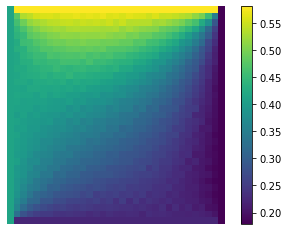

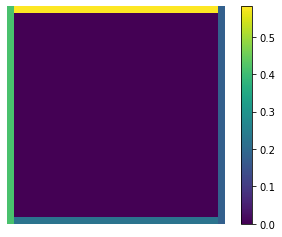

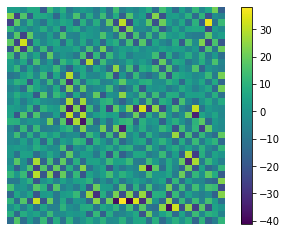

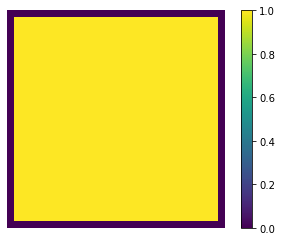

In [28]:
model_name = 'iso_poisson_33x33'

training_set = IsoPoissonDataSet('Data/IsoPoisson/poisson2d_33x33.h5')
train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
u_train, f_train, bc_value_train, bc_index_train = next(iter(train_dataloader))

k=0
plot.plot_field(u_train[k,0])
plot.plot_field(bc_value_train[k,0])
plot.plot_field(f_train[k,0])
plot.plot_field(bc_index_train[k,0])

0 3.176053047180176
1 2.3002727031707764
2 1.8371179103851318
3 1.545589566230774
4 1.343143105506897
5 1.1933447122573853
6 1.0774577856063843
7 0.984798789024353
8 0.908802330493927
9 0.8451981544494629
10 0.7910808324813843
11 0.7444013357162476
12 0.7036699056625366
13 0.6677762866020203
14 0.6358748078346252
15 0.6073093414306641
16 0.5815626382827759
17 0.5582208037376404
18 0.5369488000869751
19 0.5174722075462341
20 0.49956366419792175
21 0.4830337464809418
22 0.46772250533103943
23 0.453494668006897
24 0.44023430347442627
25 0.42784208059310913
26 0.4162318706512451
27 0.4053287208080292
28 0.3950674831867218
29 0.3853905498981476
30 0.37624746561050415
31 0.3675934076309204
32 0.35938844084739685
33 0.35159721970558167
34 0.3441879153251648
35 0.33713197708129883
36 0.3304038941860199
37 0.3239803612232208
38 0.31784042716026306
39 0.3119652569293976
40 0.3063373565673828
41 0.3009411096572876
42 0.2957621216773987
43 0.2907871603965759
44 0.2860041856765747
45 0.281402081251

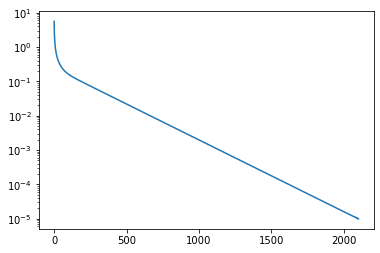

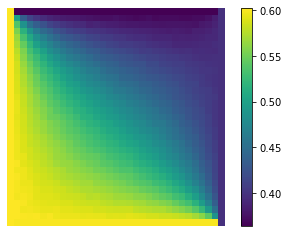

Solution from dataset:


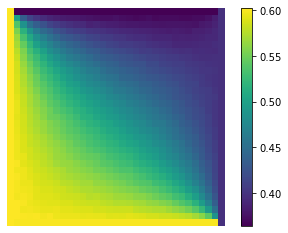

Error (dataset v.s. jacobi):


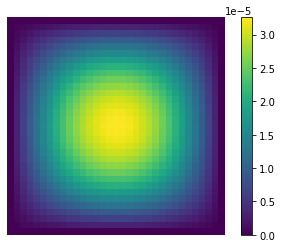

In [5]:
EPS = 1e-5
n_jac = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid.fnet(f_train[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid.ResetBoundary(bc_index_train[k,0].reshape((1,1,n+1,n+1)), bc_value_train[k,0].reshape((1,1,n+1,n+1)))
u_test = grid.jac.reset_boundary(u_test)
residual = f_test-grid.Knet(u_test)
res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
res_arr = [res]
while (abs(res) > EPS):
    u_test = grid.Relax(u_test, f_test, 1)
    residual = f_test-grid.Knet(u_test)
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. jacobi):")
plot.plot_field(u_train[k,0]-u_test.detach().reshape((1,1,n+1,n+1)))

In [6]:
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0
linear_tensor_P

tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]])

In [7]:
class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, tensor_R):
        super(RestrictionNet, self).__init__()
        self.n_channel = 1
        self.net = nn.Conv2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][0][i] = tensor_R
    def forward(self, x_split):
        return self.net(x_split)


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, tensor_P):
        super(ProlongationNet, self).__init__()
        self.n_channel = 1
        self.net = nn.ConvTranspose2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][i][0] = tensor_P
            
    def forward(self, x_split): 
        return self.net(x_split)

In [8]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, linear_tensor_P):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        # Inter-grid communication network models
        self.conv = RestrictionNet(linear_tensor_P)
        self.deconv = ProlongationNet(linear_tensor_P)
        
        self.conv.requires_grad_(True)
        self.deconv.requires_grad_(False)

        self.mse_loss = nn.MSELoss()
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids        
            
    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        Note: rF has already been splitted
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        Note: eFC has already been splitted
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def loss(self, uk, k):
        "Compute the loss after k iterations, uk is current solution"
        #err = u.clone() - u_star
        #return torch.mean(torch.norm(err, dim=(2,3)))
        #return self.mse_loss(u, u_star)
        res_k = self.f - self.grids[0].Knet(uk)
        res_last = self.f - self.grids[0].Knet(self.last_v)
        return torch.mean(torch.norm(res_k[:, :, 1:-1, 1:-1].clone(), dim=(2,3))/torch.norm(res_last[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).detach())

    '''
    def loss(self, uk, u_star):
        "Compute the loss"
        #err = u.clone() - u_star
        #return torch.mean(torch.norm(err, dim=(2,3)))
        return self.mse_loss(uk, u_star)
    '''

    def forward(self, u0, F, bc_idx, bc_value, k):
        '''Input is initial solution u0, RHS field F, boundary value B, iteration number k'''
        self.f = self.grids[0].fnet(F) # assign the finest rhs 
        self.grids[0].ResetBoundary(bc_idx, bc_value) # reset the boundary of finest grid
        self.u0 = self.grids[0].jac.reset_boundary(u0)
        U = self.u0.clone()
        
        for i in range(k-1):
            U = self.iterate(U, self.f).detach()
        self.last_v = U.clone()
        return self.iterate(U, self.f)

    def iterate(self, x, f):
        '''Input x is the initial solution on the finest grid'''
        n_batches = x.shape[0]
        n_relax = 1 # number of relaxations
        self.grids[0].v = x
        self.grids[0].f = f
        self.grids[0].v = self.grids[0].Relax(self.grids[0].v, self.grids[0].f, n_relax)

        for j in range(0, self.L-1):
            rF = self.grids[j].f-self.grids[j].Knet(self.grids[j].v)
            rF = self.grids[j].Knet.split_x(rF)
            self.grids[j+1].f = self.Restrict(rF)
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.grids[j+1].v = self.grids[j+1].Relax(self.grids[j+1].v, self.grids[j+1].f, n_relax)

        self.grids[self.L-1].v = self.grids[self.L-1].Relax(self.grids[self.L-1].v, self.grids[self.L-1].f, n_relax)

        for j in range(self.L-2,-1,-1):
            eFC = self.grids[j+1].Knet.split_x(self.grids[j+1].v)
            eF_delta = self.Interpolate(eFC)
            self.grids[j].v = self.grids[j].v + eF_delta
            self.grids[j].v = self.grids[j].Relax(self.grids[j].v, self.grids[j].f, n_relax)

            # zero out the previous level solution
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.grids[0].v 

In [9]:
def random_sampling(x):
    u = torch.randn_like(x)
    return u

In [10]:
random_P = linear_tensor_P+0.3*torch.rand((3,3))

model = MultiGrid(n, random_P)
model_linear = MultiGrid(n, linear_tensor_P)

0 4.303105354309082
1 0.9373161792755127
2 0.22404174506664276
3 0.05413199961185455
4 0.013164863921701908
5 0.0032177872490137815
6 0.000789762067142874
7 0.00019450782565400004
8 4.810877362615429e-05
9 1.2009977581328712e-05
10 3.1899073746899376e-06
Solution converges after 10 multi-grid iterations 


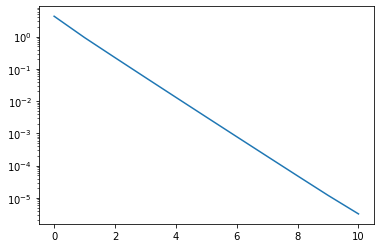

Multigrid solution:


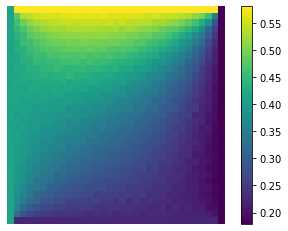

Jacobi solution:


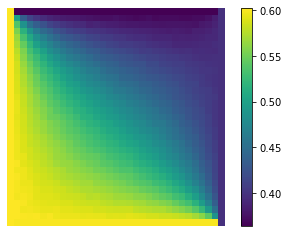

Solution from dataset:


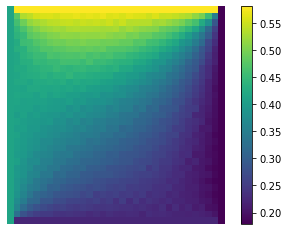

Error (dataset v.s. mg):


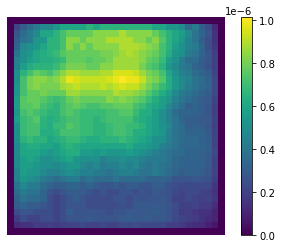

In [29]:
n_multigrid = 0
EPS = 1e-5
n = 2**5
u_mg = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_mg = f_train[k,0].reshape((1,1,n+1,n+1))
bc_idx_mg = bc_index_train[k,0].reshape((1,1,n+1,n+1))
bc_value_mg = bc_value_train[k,0].reshape((1,1,n+1,n+1))
model_linear(u_mg, f_mg, bc_idx_mg, bc_value_mg, 1)
err_occured = False
residual = model_linear.f-model_linear.grids[0].Knet(model_linear.u0)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr_linear = [res]
print(n_multigrid, res)
while (abs(res) > EPS):
    u_mg = model_linear.iterate(u_mg, model_linear.f)
    residual = model_linear.f-model_linear.grids[0].Knet(u_mg)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr_linear.append(res)
    n_multigrid += 1
    print(n_multigrid, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr_linear)
plt.yscale('log')
plt.show()

print("Multigrid solution:")
plot.plot_field(u_mg.detach())

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. mg):")
plot.plot_field(u_train[k,0]-u_mg.detach().reshape((1,1,n+1,n+1)))

In [12]:
print("q is:", res_arr_linear[-1]/res_arr_linear[-2])

q is: 0.2665643955033016


In [13]:
model_dir = 'Model/iso_poisson'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

optimizer = torch.optim.Adam(model.parameters(), lr=8e-4)
mlist = list(model.parameters())
print('Restriction kernel:', mlist[0][0][0])
print('Restriction kernel shape:', mlist[0].shape)
print('Interpolation kernel:', mlist[1][0][0])
print('Interpolation kernel shape:', mlist[1].shape)

Restriction kernel: tensor([[0.5435, 0.7183, 0.3039],
        [0.5406, 1.2671, 0.7092],
        [0.3152, 0.6472, 0.2949]], grad_fn=<SelectBackward0>)
Restriction kernel shape: torch.Size([1, 1, 3, 3])
Interpolation kernel: tensor([[0.5435, 0.7183, 0.3039],
        [0.5406, 1.2671, 0.7092],
        [0.3152, 0.6472, 0.2949]])
Interpolation kernel shape: torch.Size([1, 1, 3, 3])


In [14]:
def copy_kernels(para_list):
    '''Copy the values of R kernels to P kernels'''
    para_list[1][0,:] = para_list[0][:,0].detach()


def freeze_kernels(para_list):
    '''Freeze the [1,1] component of kernels in list'''
    para_list[0].grad[0,0,1,0] = torch.tensor(0.0)
        

def rewrite_kernels(para_list):
    '''Overwrite the kernels in list'''
    para_list[0][0,0,1,0].data = torch.tensor(0.5)

In [15]:
def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        u_train, f_train, bc_value_train, bc_index_train = data
        
        optimizer.zero_grad() # zero the gradients for every batch
        k = random.randint(1,8)
        u0 = random_sampling(f_train)

        u_out = model(u0, f_train, bc_index_train, bc_value_train, k)
        loss_i = model.loss(u_out, k)
        
        loss_i.backward()
        para_list = list(model.parameters())
        #freeze_kernels(para_list)
        optimizer.step()
        #rewrite_kernels(para_list)
        copy_kernels(para_list) # update the P kernels
        
        running_loss += loss_i.item()
    
    last_loss = running_loss/(i+1)
    return last_loss, para_list[0][0,0].data

In [16]:
num_epoch = 1000
best_vloss = 1_000_000.

loss_train = torch.zeros((num_epoch, 1))
kernel_train = torch.zeros((num_epoch, 3, 3))
for epoch in range(num_epoch):
    model.train(True)
    avg_loss, kernel_i = train_one_epoch()
    print(epoch, avg_loss)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,model_name+'.pth')
    torch.save(model.state_dict(), mpath)
    loss_train[epoch] = avg_loss
    kernel_train[epoch] = kernel_i.detach().clone()


0 2.9162847050465643
1 2.5540570113807917
2 2.5748095945455134
3 2.3036412354558706
4 1.7058140691369772
5 1.7457545516081154
6 1.2749527473933995
7 1.2022273857146502
8 0.7725048935972154
9 0.6914860303513706
10 0.622919297311455
11 0.47251404356211424
12 0.4675208041444421
13 0.2970141307450831
14 0.3849513903260231
15 0.3175140176899731
16 0.27079751808196306
17 0.21604655124247074
18 0.21714733261615038
19 0.23363267863169312
20 0.2125952746719122
21 0.18416067166253924
22 0.22257100045681
23 0.20340125961229205
24 0.23220673762261868
25 0.2006873250938952
26 0.1953847105614841
27 0.1773432269692421
28 0.21766963694244623
29 0.2319080037996173
30 0.21147817000746727
31 0.23425284959375858
32 0.20614175265654922
33 0.22882449813187122
34 0.20799698866903782
35 0.1779799684882164
36 0.15672582015395164
37 0.19127208506688476
38 0.20692689064890146
39 0.2017613616771996
40 0.21681757736951113
41 0.21015304932370782
42 0.19969983352348208
43 0.20476678339764476
44 0.1967050521634519
45

Average q:  tensor(0.1983) , STD:  tensor(0.0131)


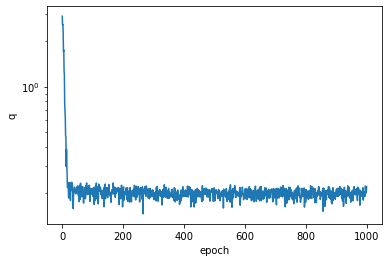

In [17]:
plt.plot(loss_train)
plt.ylabel('q')
plt.yscale('log')
plt.xlabel('epoch')
print("Average q: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

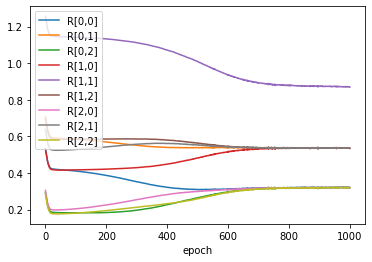

In [18]:
plt.plot(kernel_train[:,0,0], label="R[0,0]")
plt.plot(kernel_train[:,0,1], label="R[0,1]")
plt.plot(kernel_train[:,0,2], label="R[0,2]")
plt.plot(kernel_train[:,1,0], label="R[1,0]")
plt.plot(kernel_train[:,1,1], label="R[1,1]")
plt.plot(kernel_train[:,1,2], label="R[1,2]")
plt.plot(kernel_train[:,2,0], label="R[2,0]")
plt.plot(kernel_train[:,2,1], label="R[2,1]")
plt.plot(kernel_train[:,2,2], label="R[2,2]")
plt.xlabel('epoch')
plt.legend()

In [19]:
# save the list
torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))
torch.save(kernel_train, os.path.join(model_dir,model_name+'-kernels.pt'))

In [30]:
# import the learned model
#model_name = 'poisson_mg_kernel_17x17'
Ps = torch.load(os.path.join(model_dir,model_name+'-kernels.pt'))
#P = torch.mean(Ps[-100:,:,:],dim=0)
P = Ps[-1,:,:]
print('Learned Restriction/Prolongation kernel:')
print(P)

Learned Restriction/Prolongation kernel:
tensor([[0.3198, 0.5352, 0.3184],
        [0.5353, 0.8687, 0.5344],
        [0.3194, 0.5347, 0.3182]])


In [21]:
def compute_q(res_arr):
    return res_arr[-1]/res_arr[-2]

0 4.303105354309082
1 0.8379550576210022
2 0.18237589299678802
3 0.04077531024813652
4 0.009309359826147556
5 0.0021615447476506233
6 0.0005090598133392632
7 0.00012104624329367653
8 2.8986514735152014e-05
9 7.185014965216396e-06
Solution converges after 9 multi-grid iterations 


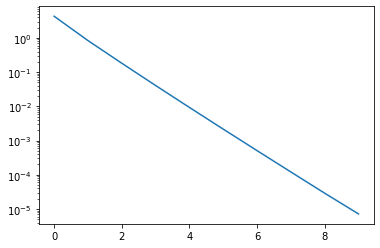

Multigrid solution:


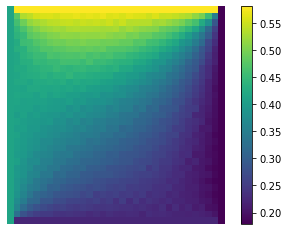

Solution from dataset:


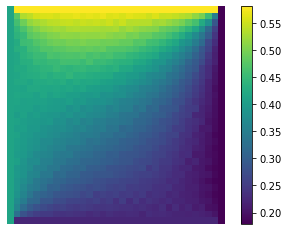

Error (dataset v.s. mg):


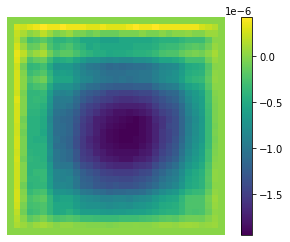

In [31]:
EPS = 1e-5
n = 2**5
model = MultiGrid(n, P) # create a new model
n_multigrid = 0
f_mg = f_train[k,0].reshape((1,1,n+1,n+1))
#u_mg = random_sampling(f_mg)
u_mg = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
bc_idx_mg = bc_index_train[k,0].reshape((1,1,n+1,n+1))
bc_value_mg = bc_value_train[k,0].reshape((1,1,n+1,n+1))
model(u_mg, f_mg, bc_idx_mg, bc_value_mg, 1)
residual = model.f-model.grids[0].Knet(model.u0)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
err_occured = False
res_arr = [res]
print(n_multigrid, res)
while (abs(res) > EPS):
    u_mg = model.iterate(u_mg, model.f)
    residual = model.f-model.grids[0].Knet(u_mg)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr.append(res)
    n_multigrid += 1
    print(n_multigrid, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

print("Multigrid solution:")
plot.plot_field(u_mg.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. mg):")
plot.plot_field(u_train[k,0]-u_mg.detach().reshape((1,1,n+1,n+1)))

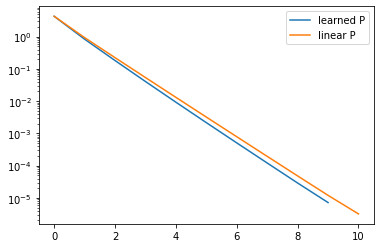

In [32]:
plt.plot(res_arr, label="learned P")
plt.plot(res_arr_linear, label="linear P")
plt.yscale('log')
plt.legend()
plt.show()

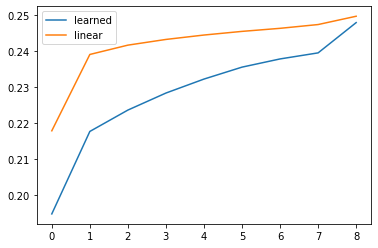

In [36]:
k = []
k_linear = []
for i in range(len(res_arr)-1):
    k.append(res_arr[i+1]/res_arr[i])
    k_linear.append(res_arr_linear[i+1]/res_arr_linear[i])

plt.plot(k, label = 'learned')
plt.plot(k_linear, label='linear')
plt.legend()

In [24]:
print("q is: ", compute_q(res_arr))
print("q hat is: " + str(float(model.loss(u_mg, len(res_arr)-1).detach())))

q is:  0.242199529176493
q hat is: 1.6256930166491657e-06


In [25]:
# Test the multigrid iteration
class mgTest(MultiGrid):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        super(mgTest, self).__init__(n, linear_tensor_P)

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs
    
    def solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.grids[0].v = self.iterate(self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 0.1887245923280716
6.571310011737677 0.2010144144296646
1.144095828095757 0.24095818400382996
3.762820113405668 0.2857430875301361
1.285842107227971 0.3394377827644348
2.8855768128300583 0.40330663323402405
1.4101545094683223 0.4792734980583191
2.47634326142357 0.5695580244064331
1.5136780448918956 0.676983654499054
2.2493800225123253 0.8048299551010132
1.5968602055764027 0.9567620754241943
2.1129421822315706 1.1371899843215942
1.6613445405017153 1.351672649383545
2.025374426743576 1.6068735122680664
1.7101370247488619 1.910357117652893
1.9679901033287657 2.270916700363159
1.7466234255282 2.699281692504883
1.9290668723158666 3.2087647914886475
1.7731105053071017 3.8148350715637207
1.9025917223887077 4.5350661277771
1.792657707102398 5.390636920928955
1.8842065802210468 6.407895565032959
1.8064153145950703 7.61809778213501
1.8714270671349325 9.056654930114746
1.816615349465342 10.765520095825195
1.8624827348472983 12.797175407409668
1.8235604961317993 15.214228630065918
1.8562154406

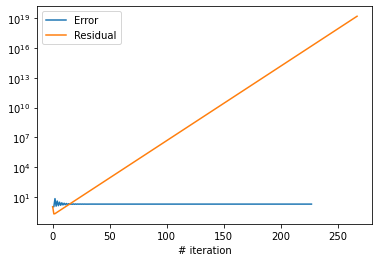

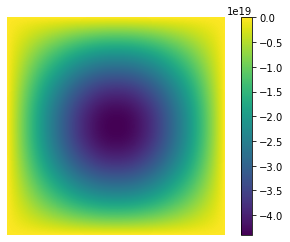

In [26]:
# Multigrid implementation
n = 2**9
model_mg = MultiGrid(n, P) # create a new model
prob_mg = mgTest(model_mg, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [27]:
print("q is: ", compute_q(res_arr_Vcycle))

q is:  inf
